# Lesson 12 - Автоэнкодеры.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Проклятие размерности

Глубокие нейросети очень хорошо подходят для обработки многомерных данных, но **чем больше размерность, тем больше примеров нужно, чтобы описать все случаи** (увеличивается по экспоненте).

<img src="imgs/curse_of_dimensionality.png" style="height:70%; width: 70%;">

**Пример**: для того, чтобы классифицировать кошек и собак по одному признаку нужно 100 примеров, тогда для двух признаков число комбинаций – $100^2$, для трех – $100^3$. 

Т.е. если у нас недостаточно тренировочных примеров, то можно выполнить сжатие исходных данных и обучить какой-нибудь простой классификатор вроде SVM на меньшем числе признаков.

## Отбор признаков вручную

Возьмем задачу **классификации выражения лица**. Очевидно, что для решения данной задачи нам не нужны все измерения (сумма всех пикселей). Например, для картинки $1024\times1024$ число признаков - $1\ 048\ 576$!

<img src="imgs/facial_keypoints.png" style="height:45%; width: 45%;">

В частности, существуют определенные ключевые признаки, позволяющие быстро определить, какие эмоции выражает лицо человека. Например, **кривая губ, изгиб бровей, а также форма глаз** помогают нам понять, что человек улыбается. Данные признаки можно обобщить, **оценив расстояния между различными ключевыми точками лица**.

## Снижение размерности

На то, чтобы для каждой задачи вручную отобрать необходимые признаки, может уйти слишком много времени. Для эффективного снижения размерности существует ряд методов. 

### Методы снижения размерности:
- PCA
- LSA
- t-SNE

Самый популярный из них **PCA - метод главных компонент**. 

*Все эти методы вы можете найти в scikit-learn.*

## Principal Components Analysis / Метод главных компонент

Идея метода заключается в поиске линейных комбинаций исходных признаков и, ценой части информации, выражение этих признаков новыми, но числом значительно меньшим, чем исходное.

Когда речь идет о науке о данных, можно часто услышать фразу: данные подчиняются распределению... **Распределение в самом простом понимании - это положение точек тренировочных примеров в многомерном пространстве признаков.** 

Для того, чтобы как-то описать распределение, можно найти **ковариационную матрицу**: 

$$cov(X) = \mathbb{E}[XX^T] - \mathbb{E}[X]\cdot\mathbb{E}[X^T]$$

Ковариационная матрица описывает взаимозависимость параметров. Размер ковариационной матрицы - $n\times n$ для $n$ признаков.

Потом производится разложение ковариационной матрицы с целью найти собственные значения (eigenvalues) и спроецировать исходные данные на **новое пространство признаков меньшей размерности**.

Подробно про метод можно прочитать по ссылке - https://habrahabr.ru/post/304214/

### Посмотрим, как это работает!

Сгенерируем данные для обучения (наше распределение) и отобразим

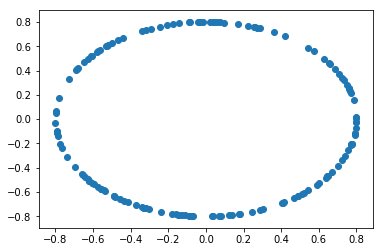

In [241]:
t = np.random.uniform(0, 2*np.pi, size=150)
dots = np.array([0.8*np.sin(t), 0.8*np.cos(t)]).T
#dots = dots / dots.max()
plt.scatter(dots[:,0], dots[:, 1])
plt.show()

Каждая точка описана двумя признаками - (x, y) координатами. Попробуем выполнить сжатие до одного признака-комбинации первых двух. **И сразу восстановим данные по одному признаку.**

In [126]:
from sklearn.decomposition import PCA

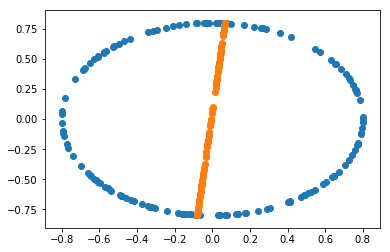

In [243]:
pca = PCA(1)

pdots = pca.fit_transform(dots)
pdots = pca.inverse_transform(pdots)
plt.scatter(dots[:,0], dots[:, 1])
plt.scatter(pdots[:,0], pdots[:, 1])
plt.show()

Можно видеть, что данные восстановились плохо - это проблема всех линейных методов вроде PCA.

## Автоэнкодер

**Автоэнкодеры** — это нейронные сети прямого распространения, которые **восстанавливают входной сигнал на выходе**. Внутри у них имеется скрытый слой, который представляет сжатое представление исходных данных. Сжатие достигается за счет того, что число нейронов на скрытом слое ограничено и, как правило, значительно меньше, чем на входном. 

<img src="imgs/ae_scheme.png" style="height:35%; width: 35%;">

Автоэнкодеры состоят из двух частей: **энкодера g и декодера f**. Энкодер переводит входной сигнал в его сжатое представление (код): h = g(x), а декодер восстанавливает сигнал по его коду: x=f(h).

Обучение заключается в минимизации ошибки между входным и выходным сигналами сети. Например, среднеквадратичное отклонение.

### Главные компоненты нейронными сетями

In [139]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import concatenate

Один скрытый слой, все активации - линейные.

In [249]:
inputs = Input((2,))
x = Dense(1, activation='linear')(inputs)
outputs = Dense(2, activation='linear')(x)

pca_net = Model(inputs, outputs)
pca_net.compile(optimizer=Adam(0.03), loss='mse')
pca_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_116 (InputLayer)       (None, 2)                 0         
_________________________________________________________________
dense_411 (Dense)            (None, 1)                 3         
_________________________________________________________________
dense_412 (Dense)            (None, 2)                 4         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


Обучим модель и попробуем восстановить исходные данные.

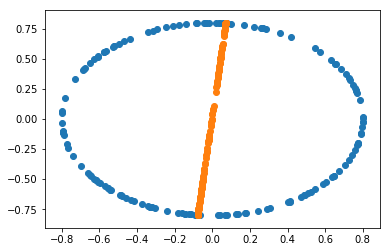

In [251]:
pca_net.fit(dots, dots, epochs=50, verbose=0)

pdots = pca_net.predict(dots)
plt.scatter(dots[:,0], dots[:, 1])
plt.scatter(pdots[:,0], pdots[:, 1])
plt.show()

## Nonlinear Principal Component Analysis

**Нелинейный метод главных компонент** - метод, [предложенный Марком Крамером](http://courses.cs.tamu.edu/rgutier/cpsc636_s10/kramer1991nonlinearPCA.pdf),
это сеть-автоэнкодер, в которой **число скрытых слоев больше одного** и активации на кодирующих и декодирующих слоях - **нелинейные (сигмоид, гиперболический тангенс и т.д.)**.

In [269]:
inputs = Input((2,))
x = Dense(6, activation='tanh')(inputs)
x = Dense(1, activation='linear')(x)
x = Dense(6, activation='tanh')(x)
outputs = Dense(2, activation='linear')(x)

nlpca = Model(inputs, outputs)
nlpca.compile(optimizer=Adam(0.1, decay=1e-3), loss='mse')
nlpca.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_133 (InputLayer)       (None, 2)                 0         
_________________________________________________________________
dense_491 (Dense)            (None, 6)                 18        
_________________________________________________________________
dense_492 (Dense)            (None, 1)                 7         
_________________________________________________________________
dense_493 (Dense)            (None, 6)                 12        
_________________________________________________________________
dense_494 (Dense)            (None, 2)                 14        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


Обучим NLPCA с тремя скрытыми слоями $6 -> 1 -> 6$ и попробуем восстановить данные.

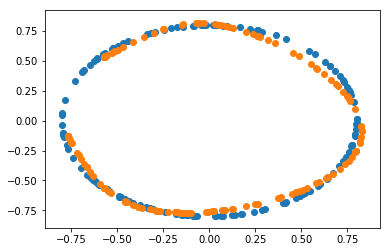

In [270]:
nlpca.fit(dots, dots, epochs=300, verbose=0)

pdots = nlpca.predict(dots)
plt.scatter(dots[:,0], dots[:, 1])
plt.scatter(pdots[:,0], pdots[:, 1])
plt.show()

По одному только компоненту такое хорошее восстановление данных! Все благодаря нелинейности такого подхода.

### Deep NLPCA

Можно попробовать добавить еще парочку скрытых слоев и посмотреть, что произойдет.

In [271]:
inputs = Input((2,))
x = Dense(6, activation='tanh')(inputs)
x = Dense(2, activation='tanh')(x)
x = Dense(1, activation='linear')(x)
x = Dense(2, activation='tanh')(x)
x = Dense(6, activation='tanh')(x)
outputs = Dense(2, activation='linear')(x)

nlpca_deep = Model(inputs, outputs)
nlpca_deep.compile(optimizer=Adam(0.1, decay=1e-3), loss='mse')
nlpca_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_134 (InputLayer)       (None, 2)                 0         
_________________________________________________________________
dense_495 (Dense)            (None, 6)                 18        
_________________________________________________________________
dense_496 (Dense)            (None, 2)                 14        
_________________________________________________________________
dense_497 (Dense)            (None, 1)                 3         
_________________________________________________________________
dense_498 (Dense)            (None, 2)                 4         
_________________________________________________________________
dense_499 (Dense)            (None, 6)                 18        
_________________________________________________________________
dense_500 (Dense)            (None, 2)                 14        
Total para

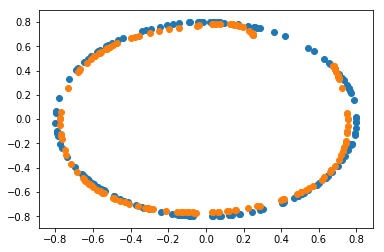

In [272]:
nlpca_deep.fit(dots, dots, epochs=300, verbose=0)

pdots = nlpca_deep.predict(dots)
plt.scatter(dots[:,0], dots[:, 1])
plt.scatter(pdots[:,0], pdots[:, 1])
plt.show()

Восстановление получилось хорошее, а теперь давайте сравним ошибки:

In [293]:
l1 = pca_net.evaluate(dots, dots, verbose=0)
l2 = nlpca.evaluate(dots, dots, verbose=0)
l3 = nlpca_deep.evaluate(dots, dots, verbose=0)

print('Mean Squared Errors:\n')
print('PCA: {:.3f}'.format(l1))
print('NLPCA: {:.3f}'.format(l2))
print('Deep Autoencoder: {:.3f}'.format(l3))

Mean Squared Errors:

PCA: 0.143
NLPCA: 0.007
Deep Autoencoder: 0.002


## Dense Autoencoders

Dense AE - это автоэнкодеры, состоящие из полносвязных *dense* слоев. Попытаемся выполнить сжатие картинок рукописных цифр MNIST до 64 компонент и восстановить исходные данные по сжатому представлению. 

Оригинальный размер картинок базы - $28\times28=784$. 64 компоненты - это 8% от исходного размера изображения. Сжатие в десять раз!

In [140]:
from keras.datasets import mnist
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Lambda
from keras.regularizers import L1L2
import keras.backend as K

Загрузка базы и нормализация. Лейблы нам пока не нужны.

In [141]:
train, test = mnist.load_data()
# normalization
x_train = train[0] / 255.
x_test = test[0] / 255.

Функция создания автоэнкодера. Регуляризатор на среднем слое нам пригодится потом.

In [142]:
def create_dense_ae(input_shape, latent_dim=64, lambda_l1=0):
    input_dim = np.prod(input_shape)
    # encoder
    encoder_in = Input(input_shape)
    # reshape to vector 
    # 28*28*1 = 784
    x = Flatten()(encoder_in) 
    x = Dense(256, activation='elu')(x)
    # bottleneck
    # activity regularizer is for sparsity
    z = Dense(latent_dim, activation='linear',
             activity_regularizer=L1L2(lambda_l1, 0))(x)

    encoder = Model(encoder_in, z, name='encoder')

    # decoder
    decoder_in = Input((latent_dim, ))
    x = Dense(256, activation='elu')(decoder_in)
    x = Dense(input_dim, activation='sigmoid')(x)
    # reshape to original shape
    output = Reshape(input_shape)(x)

    decoder = Model(decoder_in, output, name='decoder')

    # construct autoencoder
    ae_output = decoder(encoder(encoder_in))
    autoencoder = Model(encoder_in, ae_output, name='autoencoder')
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return encoder, decoder, autoencoder


encoder, decoder, autoencoder = create_dense_ae(x_train.shape[1:])

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 64)                217408    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            218128    
Total params: 435,536
Trainable params: 435,536
Non-trainable params: 0
_________________________________________________________________


В качестве функции ошибки используется перекрестная энтропия, а не среднеквадратичное отклонение. 

Это потому, что использовать евклидово расстояние можно только в случае, если данные подчиняются нормальному закону, но картинки рукописных цифр не лежат в нормальном распределении, поэтому лучше использовать кросс-энтропию или метод максимального правдоподобия.

Идея замены разности квадратов на другую метрику вроде кросс-энтропии очень хорошо развита в генеративных состязательных сетях, о которых речь пойдет на следующем занятии. 

In [446]:
autoencoder.fit(x_train, x_train, epochs=3, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 75s 1ms/step - loss: 0.1065 - val_loss: 0.0807
Epoch 2/3
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0784 - val_loss: 0.0753
Epoch 3/3
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0747 - val_loss: 0.0733


Вспомогательная функция для отображения результатов восстановления.

In [6]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])

    plt.figure(figsize=(n, len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n+j+1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

Вуаля, сверху оригинальные картинки, а снизу - восстановленные из 64 компонент. 

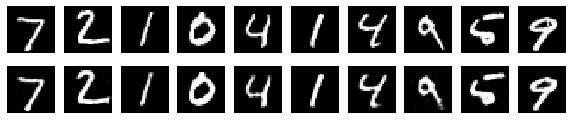

In [448]:
n = 10
imgs = x_test[:n]
pred = autoencoder.predict(imgs)

plot_digits(imgs, pred)

# Sparse Autoencoders

Как правило, при обучении автоэнкодеров нейроны на среднем кодирующем слое **активируются слишком часто для большей части тренировочных примеров**. Но если мы хотим, чтобы каждый признак был максимально независим от других компонент, нужно наложить **ограничение разреженности**. Мы хотим сделать так, чтобы каждый скрытый нейрон среднего слоя реагировал лишь на малую часть тренировочных данных - **разреженная активация**.

<img src='imgs/sparsity.jpg' style="height:60%; width: 50%;">

Для того, чтобы превратить обычный автоэнкодер в разреженный, просто добавляем L1 регуляризатор на активации среднего bottle-neck слоя.

In [478]:
s_encoder, s_decoder, s_autoencoder = create_dense_ae(x_train.shape[1:], lambda_l1=1e-5)

s_autoencoder.summary()
s_autoencoder.fit(x_train, x_train, epochs=3, validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_160 (InputLayer)       (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 64)                217408    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            218128    
Total params: 435,536
Trainable params: 435,536
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 87s 1ms/step - loss: 0.1298 - val_loss: 0.0986
Epoch 2/3
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0947 - val_loss: 0.0903
Epoch 3/3
60000/60000 [==============================] - 77s 1ms/step - loss: 0.0883 - val_loss: 0.0859


Можно посмотреть на среднее значение активации скрытого кодирующего слоя.

In [480]:
print('Not sparse mean encoding:', encoder.predict(x_test).mean())
print('Sparse mean encoding:', s_encoder.predict(x_test).mean())

Not sparse mean encoding: 0.149991
Sparse mean encoding: 0.0157852


## Denoising Autoencoder

Кроме извлечения признаков, автоэнкодеры обладают еще одним замечательным свойством - **шумоподавление**. Автоэнкодеры можно обучить убирать шум из данных: для этого надо на вход подавать зашумленные данные и на выходе сравнивать с данными без шума.

<img src='imgs/denoising_ae.jpg'>

В Keras есть Lambda слой, с помощью которого можно конструировать свои слои. Создадим структуру, которая позволит генерировать нормальный шум с коэффициентом $0.5 - 50\%$ зашумления.

In [491]:
def create_denoising_model(autoencoder, batch_size):
    batch_shape = [batch_size]+list(autoencoder.inputs[0].shape[1:])
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x
    input_ = Input(batch_shape=batch_shape)
    noisy_img = Lambda(add_noise)(input_)

    noiser = Model(input_, noisy_img, name='noiser')
    ae_output = autoencoder(noiser(input_))
    denoising_ae = Model(input_, ae_output, name='denoiser')
    denoising_ae.compile(optimizer=Adam(0.01), loss='binary_crossentropy')
    
    return noiser, denoising_ae

In [498]:
batch_size = 32
noiser, dae = create_denoising_model(autoencoder, batch_size)
dae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_169 (InputLayer)       (32, Dimension(28), Dimen 0         
_________________________________________________________________
noiser (Model)               (32, 28, 28)              0         
_________________________________________________________________
autoencoder (Model)          multiple                  435536    
Total params: 435,536
Trainable params: 435,536
Non-trainable params: 0
_________________________________________________________________


In [499]:
dae.fit(x_train, x_train, epochs=3, shuffle=True)

Epoch 1/3
60000/60000 [==============================] - 79s 1ms/step - loss: 0.1647
Epoch 2/3
60000/60000 [==============================] - 74s 1ms/step - loss: 0.1315
Epoch 3/3
60000/60000 [==============================] - 74s 1ms/step - loss: 0.1249


Посмотрим, как наш автоэнкодер справляется с уровнем зашумления $50\%$.

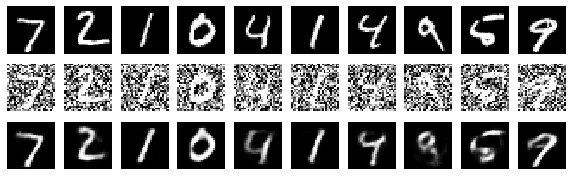

In [503]:
n = 10
imgs = x_test[:batch_size]

noisy_imgs = noiser.predict(imgs, batch_size = batch_size)
enc_imgs = encoder.predict(noisy_imgs[:n], batch_size = n)
dec_imgs = decoder.predict(enc_imgs[:n], batch_size = n)

plot_digits(imgs[:n], noisy_imgs, dec_imgs)

## VAE motivation

Изображения цифр mnist — это элементы 784-мерного пространства (число признаков $28\times28$).

Однако среди всех изображений, изображения цифр занимают лишь ничтожную часть, абсолютное же большинство изображений - это просто шум. С другой стороны, если взять произвольное изображение цифры, то и все изображения из некоторой окрестности также можно считать цифрой.

Таким образом, в пространстве всех изображений есть некоторое подпространство меньшей размерности в области вокруг которого сосредоточились изображения цифр. То есть, если наша генеральная совокупность — это все изображения цифр, которые могут быть нарисованы в принципе, то плотность вероятности встретить такую цифру в пределах области сильно выше, чем вне.

Автоэнкодеры со скрытым слоем из k нейронов ищут k-мерное многообразие в пространстве объектов, которое наиболее полно передает все вариации в выборке. А сам код задает параметризацию этого многообразия. При этом энкодер сопоставляет объекту его параметр на многообразии, а декодер параметру сопоставляет точку в пространстве объектов.

Возьмем два различных изображения восьмерок из нашей выборки. Построим их **гомотопию** - непрерывное отображение одной картинки в другую. 

In [449]:
def plot_homotopy(frm, to, n=10, decoder=None):
    z = np.zeros(([n] + list(frm.shape)))
    for i, t in enumerate(np.linspace(0., 1., n)):
        z[i] = frm * (1-t) + to * t
    if decoder:
        plot_digits(decoder.predict(z, batch_size=n))
    else:
        plot_digits(z)

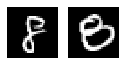

In [450]:
imgs = x_test[test[1] == 8][200:202]
plot_digits(imgs)

Сначала двигаемся по прямой в пространстве цифр от одной 8-ки к другой.

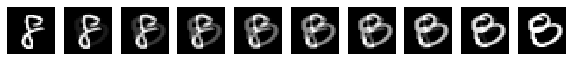

In [451]:
from_, to = imgs[0], imgs[1]
plot_homotopy(from_, to)

Можно заметить, что плавного перехода не происходит, так как промежуточные изображения, скорее всего, **не принадлежат генеральной совокупности** по причине сильной искривленности многообразия, на котором она лежит.

Но если мы попробуем проделать такой же трюк с предварительно закодированными восьмерками, которые восстанавливаются в исходные изображения с помощью декодера, то сможем наблюдать плавный переход. То есть мы двигаемся по кривой между кодами, при этом декодер переводит кривую из пространства кодов в пространство не покидающее наше многообразие. 

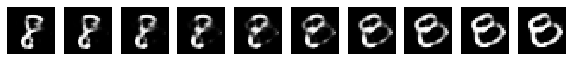

In [452]:
# latent represantation
zs = encoder.predict(imgs)
plot_homotopy(zs[0], zs[1], n=10, decoder=decoder)

Наши закодированные представления, данные со среднего скрытого слоя - это признаки по которым декодер пытается восстановить изображение (цифры в данном случае). Каждый признак может обозначать что угодно - например, номер цифры, наклон, толщину и т.д.

Но если даже попытаться сгенерировать признаки случайным образом, то декодер все равно попробует восстановить изображение цифры. 

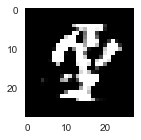

In [468]:
noise = np.random.normal(loc=2, scale=10, size=(1, 64))

plt.figure(figsize=(2,2))
plt.imshow(decoder.predict(noise)[0])
plt.grid(False)
plt.show()

То есть, имея распределение из скрытых переменных - различные варианты комбинаций значений признаков - можно **генерировать новые изображения** из многообразия данных. 

За процесс генерации отвечает семейство вариационных автоэнкодеров - VAE.

## Variational Autoencoder

**Вариационные автоэнкодеры (Variational Autoencoders)** — это автоэнкодеры, которые учатся отображать объекты в заданное скрытое пространство и, соответственно, генерировать из него. Этот вид нейросетей относят к генеративным моделям.

<img src='imgs/vae.png' style="width:60%;">

Скрытое пространство - это и есть распределение скрытых признаков, из которого можно генерировать новые объекты. Плотность нормального распределения характеризуется двумя параметрами - среднее $\mu$ и отклонение $\sigma$.

<img src='imgs/normal_distrib.jpg' style="width:60%;">

Суть работы VAE в том, чтобы на скрытом слое сгенерировать вместо главных компонент **параметры распределения скрытых признаков**. 

При этом нужно это самое распределение привести к удобному виду (нормальный закон). Делается это при помощи **минимизации расстояния Кульбака-Лейблера**.

**Расстояние Кульбака-Лейблера** - это мера удалённости друг от друга двух вероятностных распределений.

<img src='imgs/learn_vae.png'>

In [93]:
from keras.objectives import binary_crossentropy

In [122]:
def create_vae(input_shape, batch_size, latent_dim=2):    
    # Encoder
    input_dim = np.prod(input_shape)
    inputs = Input(input_shape)
    # flatten into vector
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    
    # distribution parameters: mean and std
    # instead of using std - log(variance)
    # Dense with linear activation
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        #  f(x)+eps
        eps = K.random_normal(shape=(batch_size, latent_dim))
        return z_mean + K.exp(z_log_var / 2)*eps
    
    # sampling layer
    # this layer generate 'good' distribution
    l = Lambda(sampling, (latent_dim,))([z_mean, z_log_var])
    
    encoder = Model(inputs, l, name='Encoder')
    z_meaner = Model(inputs, z_mean, name='Enc_z_mean')
    z_lvarer = Model(inputs, z_log_var, name='Enc_z_log_var')
    
    # Decoder
    z = Input((latent_dim,))
    x = Dense(256, activation='relu')(z)
    x = Dense(input_dim, activation='sigmoid')(x)
    output = Reshape(input_shape)(x)
    
    decoder = Model(z, output, name='decoder')
    vae = Model(inputs, decoder(encoder(inputs)), name='VAE')
    
    # specific variational loss
    def vae_loss(x, x_):
        # x - True value
        # x_ - predicted value
        x = K.reshape(x, shape=(batch_size, -1))
        x_ = K.reshape(x_, shape=(batch_size, -1))
        # cross entropy
        ce = input_dim*binary_crossentropy(x, x_)
        # kullback–leibler loss
        kl = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - 
            K.exp(z_log_var), axis=-1)
        
        return (ce + kl) / 2 / input_dim 
    
    models = {}
    models['encoder'] = encoder
    models['decoder'] = decoder
    models['vae'] = vae
    models['z_meaner'] = z_meaner
    models['z_lvarer'] = z_lvarer

    return (models, vae_loss)

Попробуем создать модель вариационного автоэнкодера

In [123]:
# len(train) // batch_size == 0
# len(test) // batch_size == 0
batch_size = 100

models, vae_loss = create_vae(x_train.shape[1:], batch_size)

vae = models['vae']
generator = models['decoder']
enc_mean = models['z_meaner']

vae.compile(optimizer='rmsprop', loss=vae_loss)

Посмотрим на число параметров каждой части модели.

In [117]:
for k, m in models.items():
    print(k.upper())
    m.summary()
    print()

DECODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_141 (Dense)            (None, 256)               768       
_________________________________________________________________
dense_142 (Dense)            (None, 784)               201488    
_________________________________________________________________
reshape_28 (Reshape)         (None, 28, 28)            0         
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________

ENCODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           (None, 28, 28)       

Обучим на данных рукописных цифр. Число эпох 30 лишь для демонстрации, так как этого явно мало для сходимости.

In [124]:
vae.fit(x_train, x_train, shuffle=True, epochs=30,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 38s 626us/step - loss: 0.1221 - val_loss: 0.1105
Epoch 2/30
60000/60000 [==============================] - 28s 473us/step - loss: 0.1088 - val_loss: 0.1066
Epoch 3/30
60000/60000 [==============================] - 31s 522us/step - loss: 0.1057 - val_loss: 0.1046
Epoch 4/30
60000/60000 [==============================] - 28s 464us/step - loss: 0.1037 - val_loss: 0.1033
Epoch 5/30
60000/60000 [==============================] - 32s 531us/step - loss: 0.1025 - val_loss: 0.1020
Epoch 6/30
60000/60000 [==============================] - 32s 541us/step - loss: 0.1016 - val_loss: 0.1014
Epoch 7/30
60000/60000 [==============================] - 29s 485us/step - loss: 0.1010 - val_loss: 0.1007
Epoch 8/30
60000/60000 [==============================] - 33s 546us/step - loss: 0.1005 - val_loss: 0.1003
Epoch 9/30
60000/60000 [==============================] - 30s 502us/step - loss: 0.1001 - val_

Посмотрим на восстанавливающую способность нашего автоэнкодера.

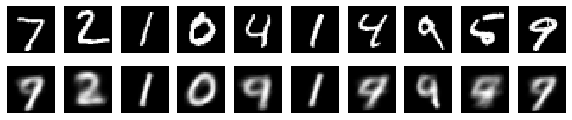

In [127]:
n = 10

imgs = x_test[:batch_size]
imgs_pred = vae.predict(imgs, batch_size=batch_size)

plot_digits(imgs[:n], imgs_pred[:n])

Видно, что многие цифры смазаны или вообще похожи на другие (четверка на девятку). Это происходит потому, что в пространстве параметров сжатые представления этих чисел похожи друг на друга - по наклону, толщине и др.

### Plotting results

Распределение

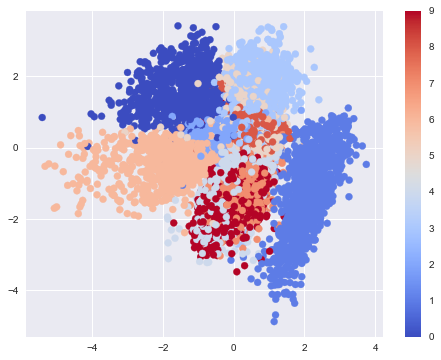

In [128]:
x_test_encoded = models['encoder'].predict(x_test, 
        batch_size=batch_size)

plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=test[1], cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

Многообразие

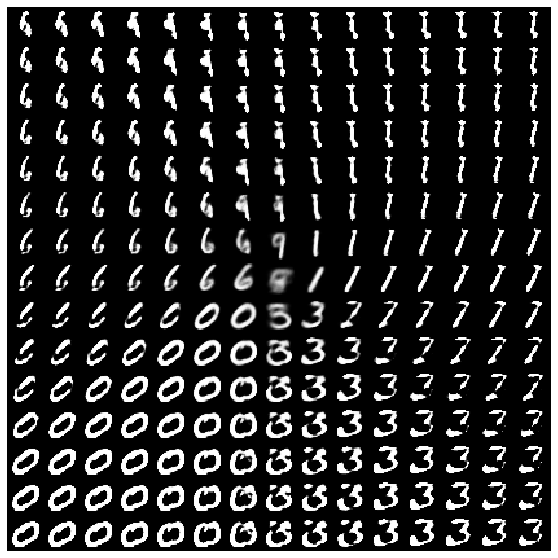

In [129]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
latent_dim = 2

figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.zeros((1, latent_dim))
        z_sample[:, :2] = np.array([[xi, yi]])
        
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].squeeze()
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.grid(False)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

Видно, что размерности 2 для такой задачи очень мало, цифры очень размытые, а так же в промежутках между хорошими много рваных цифр. Модель недоучена, так что результат на картинке выше не сильно впечатляет.

# Conditional Autoencoder

Многообразия, на которых лежат цифры разных лейблов, могут находится далеко друг от друга в пространстве картинок. Например, цифра 0 и цифра 1 - как непрерывно отобразить переход от нуля к единице?

Автоэнкодер может отображать данные в сжатое представление и обратно **только непрерывно**, так как сам является композицией непрерывных функций. 

Но ведь многообразие всех цифр не обязательно должно быть **линейно связанным**.

In [190]:
n_dots = 1000

# create data
x1 = np.linspace(-2.2, 2.2, n_dots)
fx = np.sin(x1)
dots1 = np.vstack([x1, fx]).T

t = np.linspace(0, 2*np.pi, num=n_dots)
dots2 = 0.5*np.array([np.sin(t), np.cos(t)]).T + np.array([1.5, -0.5])[None, :]

dots = np.vstack([dots1, dots2])
noise = 0.06 * np.random.randn(*dots.shape)

labels = np.array([0]*n_dots + [1]*n_dots)
noised = dots + noise

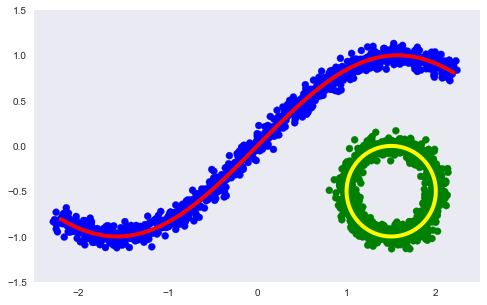

In [191]:
# visualization
colors = ['b']*n_dots + ['g']*n_dots
plt.figure(figsize=(8, 5))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.plot(dots1[:, 0], dots1[:, 1],  color="red",    linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1],  color="yellow", linewidth=4)
plt.grid(False)
plt.show()

Попробуем выучить многообразие с помощью обычного Dense Autoencoder.

In [192]:
inputs = Input((2,))
x = Dense(64, activation='elu')(inputs)
x = Dense(64, activation='elu')(x)
x = Dense(1, activation='linear')(x)
x = Dense(64, activation='elu')(x)
x = Dense(64, activation='elu')(x)
outputs = Dense(2, activation='linear')(x)

ae = Model(inputs, outputs)
ae.compile(optimizer=Adam(0.001), loss='mse')

ae.fit(noised, noised, epochs=150, batch_size=30, verbose=1)

Построим на графике результат восстановления

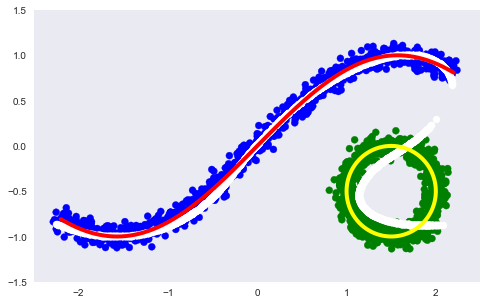

In [193]:
# Результат
predicted = ae.predict(noised)

# Визуализация
plt.figure(figsize=(8, 5))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.plot(dots1[:, 0], dots1[:, 1],  color="red",    linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1],  color="yellow", linewidth=4)
plt.scatter(predicted[:, 0], predicted[:, 1], c='white', s=50)
plt.grid(False)
plt.show()

Видно, что у простого автоэнкодера не получилось выучить форму несвязного многообразия. Вместо этого он хитро продолжил одно в другое.

Определить область из многообразия данных, к которому принадлежит определенный тренировочный пример, можно с помощью **лейблов**, которые определяют **на каком из частей несвязного многообразия лежат эти данные** (как с цифрами).

Для того, чтобы создать автоэнкодер с условием (conditional autoencoder, CAE), нужно **на вход энкодеру и декодеру подавать дополнительный признак** - метку класса, например. Возьмем ту же модель и добавим в нее такую возможность.

In [198]:
input_pnt = Input((2,))
input_lbl = Input((1,))
# concatenate two feature vectors
inputs = concatenate([input_pnt, input_lbl])

x = Dense(64, activation='elu')(inputs)
x = Dense(64, activation='elu')(x)
x = Dense(1, activation='linear')(x)

decoder_in = concatenate([x, input_lbl])
x = Dense(64, activation='elu')(decoder_in)
x = Dense(64, activation='elu')(x)
outputs = Dense(2, activation='linear')(x)

ae = Model([input_pnt, input_lbl], outputs)
ae.compile(optimizer=Adam(0.001), loss='mse')

ae.fit([noised, labels], noised, epochs=300, batch_size=30, verbose=1)

Epoch 1/300
2000/2000 [==============================] - 8s 4ms/step - loss: 0.2065
Epoch 2/300
2000/2000 [==============================] - 0s 190us/step - loss: 0.0468
Epoch 3/300
2000/2000 [==============================] - 0s 178us/step - loss: 0.0450
Epoch 4/300
2000/2000 [==============================] - 0s 152us/step - loss: 0.0447
Epoch 5/300
2000/2000 [==============================] - 1s 284us/step - loss: 0.0435
Epoch 6/300
2000/2000 [==============================] - 1s 265us/step - loss: 0.0424
Epoch 7/300
2000/2000 [==============================] - 1s 328us/step - loss: 0.0423
Epoch 8/300
2000/2000 [==============================] - 1s 343us/step - loss: 0.0415
Epoch 9/300
2000/2000 [==============================] - 1s 251us/step - loss: 0.0417
Epoch 10/300
2000/2000 [==============================] - 0s 222us/step - loss: 0.0420
Epoch 11/300
2000/2000 [==============================] - 0s 190us/step - loss: 0.0414
Epoch 12/300
2000/2000 [==============================

2000/2000 [==============================] - 0s 194us/step - loss: 0.0337
Epoch 96/300
2000/2000 [==============================] - 0s 236us/step - loss: 0.0343
Epoch 97/300
2000/2000 [==============================] - 0s 206us/step - loss: 0.0336
Epoch 98/300
2000/2000 [==============================] - 0s 188us/step - loss: 0.0333
Epoch 99/300
2000/2000 [==============================] - 0s 200us/step - loss: 0.0328
Epoch 100/300
2000/2000 [==============================] - 0s 208us/step - loss: 0.0332
Epoch 101/300
2000/2000 [==============================] - 0s 198us/step - loss: 0.0331
Epoch 102/300
2000/2000 [==============================] - 0s 188us/step - loss: 0.0327
Epoch 103/300
2000/2000 [==============================] - 1s 272us/step - loss: 0.0321
Epoch 104/300
2000/2000 [==============================] - 1s 270us/step - loss: 0.0320
Epoch 105/300
2000/2000 [==============================] - 0s 230us/step - loss: 0.0317
Epoch 106/300
2000/2000 [=========================

2000/2000 [==============================] - 0s 196us/step - loss: 0.0140
Epoch 189/300
2000/2000 [==============================] - 0s 213us/step - loss: 0.0129
Epoch 190/300
2000/2000 [==============================] - 0s 203us/step - loss: 0.0128
Epoch 191/300
2000/2000 [==============================] - 0s 193us/step - loss: 0.0137
Epoch 192/300
2000/2000 [==============================] - 0s 208us/step - loss: 0.0135
Epoch 193/300
2000/2000 [==============================] - 0s 228us/step - loss: 0.0134
Epoch 194/300
2000/2000 [==============================] - 1s 262us/step - loss: 0.0128
Epoch 195/300
2000/2000 [==============================] - 0s 222us/step - loss: 0.0129
Epoch 196/300
2000/2000 [==============================] - 0s 206us/step - loss: 0.0125
Epoch 197/300
2000/2000 [==============================] - 0s 206us/step - loss: 0.0126
Epoch 198/300
2000/2000 [==============================] - 0s 204us/step - loss: 0.0126
Epoch 199/300
2000/2000 [=====================

2000/2000 [==============================] - 0s 188us/step - loss: 0.0073
Epoch 282/300
2000/2000 [==============================] - 0s 208us/step - loss: 0.0078
Epoch 283/300
2000/2000 [==============================] - 0s 244us/step - loss: 0.0067
Epoch 284/300
2000/2000 [==============================] - 0s 246us/step - loss: 0.0083
Epoch 285/300
2000/2000 [==============================] - 1s 262us/step - loss: 0.0072
Epoch 286/300
2000/2000 [==============================] - 0s 220us/step - loss: 0.0068
Epoch 287/300
2000/2000 [==============================] - 0s 222us/step - loss: 0.0069
Epoch 288/300
2000/2000 [==============================] - 0s 197us/step - loss: 0.0069
Epoch 289/300
2000/2000 [==============================] - 0s 212us/step - loss: 0.0070
Epoch 290/300
2000/2000 [==============================] - 0s 214us/step - loss: 0.0067
Epoch 291/300
2000/2000 [==============================] - 0s 208us/step - loss: 0.0063
Epoch 292/300
2000/2000 [=====================

Отобразим результат обучения на графике.

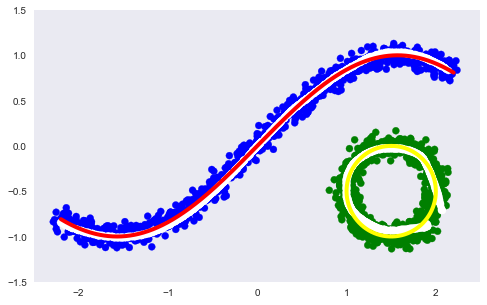

In [199]:
# Результат
predicted = ae.predict([noised, labels])

# Визуализация
plt.figure(figsize=(8, 5))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.plot(dots1[:, 0], dots1[:, 1],  color="red",    linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1],  color="yellow", linewidth=4)
plt.scatter(predicted[:, 0], predicted[:, 1], c='white', s=50)
plt.grid(False)
plt.show()

На этот раз автоэнкодеру удалось выучить линейно несвязное определяющее многообразие.

## Вывод

Автоэнкодеры - это мощный механизм, позволяющий выполнять эффективное нелинейное сжатие исходных данных. 

Данная нейросеть будет также обладать свойством шумоподавления, если при обучении на вход подавать "испорченные" изображения, минимизируя при этом ошибку с исходными "чистыми".

Вариационные автоэнкодеры позволяют генерировать новые данные из пространства скрытых признаков. 

В случае, если многообразие данных делится на линейно несвязанные области, то следует применить условие - добавить метку класса на входе, в дополнение к входным признакам.

## Ссылки

Занятие подготовленно на основе цикла статей про автоэнкодеры:
- [Часть 1: Введение](https://habrahabr.ru/post/331382/)
- [Часть 2: Manifold learning и скрытые (latent) переменные](https://habrahabr.ru/post/331500/)
- [Часть 3: Вариационные автоэнкодеры (VAE)](https://habrahabr.ru/post/331552/)
- [Часть 4: Conditional VAE](https://habrahabr.ru/post/331664/)